# COVID SIR Model
Initially written on 3/23, the day the stay home order came in (this was just days after travelling back from Olin).

In [35]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [37]:
def update_func(state, t, system):
    """Update the COVID model.

    state: State with variables S, E, I_mild, I_mod, I_fatal, R, D
    t: time step
    system: System with parameters pop, inv_day, R0, init_inf, init_deaths, init_recs, death_rate, T_inc, T_inf, T_death, T_hosp, T_rec,
        hosp_rate, T_tohosp, Rt

    returns: State object
    """
    s, e, i_mild, i_mod, i_fatal, r, d = state

    # infections/activations
    total_inf = i_mild + i_mod + i_fatal

    susceptible = -system.R0 / system.T_inf * total_inf * s / system.people
    exposed = system.R0 / system.T_inf * total_inf * s / system.people - system.T_inc**-1 * e
    infected = system.T_inc**-1 * e - system.T_inf**-1 * total_inf
    removed = system.T_inf**-1 * total_inf

    inf_mild = infected * (1 - system.hosp_rate)
    inf_mod = infected * (system.hosp_rate - system.death_rate)
    inf_fatal = infected * system.death_rate

    deaths = removed * system.death_rate
    recovered = removed * (1 - death_rate)

    s += susceptible * system.dt
    e += exposed * system.dt
    i_mild += inf_mild * system.dt
    i_mod += inf_mod * system.dt
    i_fatal += inf_fatal * system.dt
    r += recovered * system.dt
    d += deaths * system.dt

    if t == system.inv_day:
        system.R0 = system.Rt

    return State(S=s,
                 E=e,
                 I_mild=i_mild,
                 I_mod=i_mod,
                 I_fatal=i_fatal,
                 R=r,
                 D=d)

In [38]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    Adds a TimeFrame to the System: results

    system: System object
    update_func: function that updates state
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)

    for t in ts:
        frame.row[t + dt] = update_func(frame.row[t], t, system)

    return frame

In [39]:
def plot_results_lines(results, system, cases, offset):
    """Plot the results of the COVID model
    """
    xNums = [0, 60, 120, 180, 240, 300, 360]
    #     xNums = [0, 30, 60, 90, 120, 150, 180, 210, 240]
    #     xNums = [0, 5, 10, 15, 20, 25, 30]
    fig, (pl1,
          pl2) = plt.subplots(1, 2,
                              figsize=(16,
                                       4))  # create 2 subplots, right & left

    color = 'tab:green'
    pl1.set_xlabel('Days from infection')
    pl1.set_ylabel('Susceptible', color=color)
    s, = pl1.plot(results.S, color=color)
    pl1.tick_params(axis='y', labelcolor=color)
    plt.xticks(xNums)

    ax1 = pl1.twinx(
    )  # instantiate a second axis on pl1 that shares the same x-axis
    color = 'tab:purple'
    ax1.set_ylabel('Exposed',
                   color=color)  # we already handled the x-label with ax1
    e, = ax1.plot(results.E, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'
    pl2.set_xlabel('Days from infection')
    i, = pl2.plot(results.I_mild + results.I_mod + results.I_fatal,
                  color=color)
    pl2.set_ylabel('Infected and Hospitalized', color=color)
    h, = pl2.plot(results.I_mod + results.I_fatal,
                  color=color,
                  linestyle='dashed')
    pl2.plot(range(offset, len(cases) + offset), cases, 'k')
    pl2.tick_params(axis='y', labelcolor=color)
    plt.xticks(xNums)

    ax2 = pl2.twinx(
    )  # instantiate a second axis on pl2 that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Deaths', color=color)
    d, = ax2.plot(results.D, color=color)
    ax2.plot(results.I_mild + results.I_mod + results.I_fatal + results.D,
             'b',
             linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor=color)

    pl1.legend((s, e), ('Susceptible', 'Exposed'),
               fontsize=12,
               loc='upper right')
    pl2.legend((i, h, d), ('Infected', 'Hospital', 'Deaths'),
               fontsize=12,
               loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [40]:
def plot_results(results, system):
    """Plot the results of the COVID model
    """
    green = 'tab:green'
    purple = 'tab:purple'
    red = 'tab:red'
    orange = 'tab:orange'
    blue = 'tab:blue'
    yellow = 'tab:yellow'
    magenta = 'tab:magenta'
    cyan = 'tab:cyan'
    X = range(len(results.S))
    plt.stackplot(X,
                  results.D,
                  results.I_mod + results.I_fatal,
                  results.I_mild,
                  results.E,
                  labels={'death', 'hospital', 'infected but mild', 'exposed'},
                  colors={purple, blue, green, orange})

    xNums = [0, 60, 120, 180, 240, 300, 360]
    plt.xticks(xNums)

    plt.show()

[  0.15468857  -0.61723644   9.78865516 -17.81840176]
start day to match model with wiki data is day index 11, 3/9, with R = 2.4 contagiousness
11,3/9  26,3/23  30,3/27  35,4/1  42,4/8  49,4/15  56,4/22  63,4/29  64,4/30
given that 3/9 is the day when 162 cases originated and that 3/23, today, when the stay home order came in, is 15 days later, intervention on day 15.
however, given that there are likely a few thousand along and haven't tested etc... i think i can bump the intervention date up to somewhere from 15-30


Text(0.5, 1.0, 'Confirmed COV-19 cases in WA according to Wiki vs. this model')

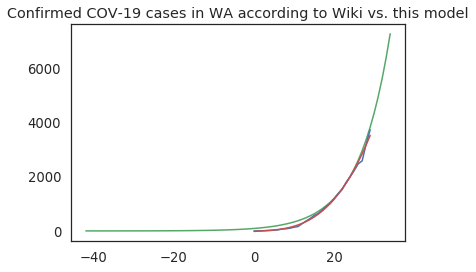

In [58]:
cases = [
    1, 3, 6, 13, 18, 28, 39, 70, 80, 102, 136, 162, 267, 366, 457, 568, 642,
    769, 904, 1012, 1187, 1376, 1524, 1793, 1996, 2221, 2469, 2580, 3202, 3723
]
deaths = [
    0, 0, 1, 2, 6, 9, 10, 10, 11, 16, 18, 22, 24, 29, 31, 37, 40, 42, 48, 52,
    66, 74, 83, 94, 95, 110, 123, 132, 147, 175
]

import numpy
z = np.polyfit(range(len(cases)), cases, 3)
print(z)
bf = []
ln = len(cases)
for i in range(ln):
    n = 0
    for j in range(len(z)):
        n += z[j] * i**(len(z) - j - 1)
    bf.append(n)

print(
    'start day to match model with wiki data is day index 11, 3/9, with R = 2.4 contagiousness'
)
print(
    '11,3/9  26,3/23  30,3/27  35,4/1  42,4/8  49,4/15  56,4/22  63,4/29  64,4/30'
)
print(
    'given that 3/9 is the day when 162 cases originated and that 3/23, today, when the stay home order came in, is 15 days later, intervention on day 15.'
)
print(
    'however, given that there are likely a few thousand along and haven\'t tested etc... i think i can bump the intervention date up to somewhere from 15-30'
)

start_day = 0
inv_day = 15
inv_per = 0.5
people = 7.8 * 10**6  # population size (susceptible) [people]
R0 = 2.4  # contagtiousness: number each infected person infects
init_inf = cases[start_day]  # initial infections [people]
init_deaths = deaths[start_day]  # initial deaths [people]
init_recs = 0  # initial recoveries [people]
death_rate = 0.02  # percent death rate
T_inc = 5.2  # infection incubation period [days]
T_inf = 2.9  # duration of infectiousness [days]
T_death = 32  # time until death [days]
T_hosp = 28.6  # length of hospital stay [days]
T_rec = 11.1  # time recovering from mild case [days]
hosp_rate = 0.20  # hospitalization percent
T_tohosp = 5  # time until ending up in hospital [days]
Rt = (1.0 - inv_per) * R0  # modified contagiousness factor after inv_day

# without intervention
system = make_system(people, inv_day, R0, init_inf, init_deaths, init_recs,
                     death_rate, T_inc, T_inf, T_death, T_hosp, T_rec,
                     hosp_rate, T_tohosp, R0)
results = run_simulation(system, update_func)

daycount = len(cases) + 5
offset = 42
index = daycount - start_day + offset
plt.plot(
    range(start_day - offset, daycount), results.I_mild[0:index] +
    results.I_mod[0:index] + results.I_fatal[0:index], 'g')
plt.plot(cases, 'b')
plt.plot(bf, 'r')
plt.title('Confirmed COV-19 cases in WA according to Wiki vs. this model')

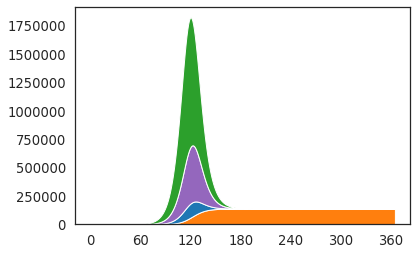

In [55]:
# without intervention
system = make_system(people, inv_day, R0, init_inf, init_deaths, init_recs,
                     death_rate, T_inc, T_inf, T_death, T_hosp, T_rec,
                     hosp_rate, T_tohosp, R0)
results = run_simulation(system, update_func)
plot_results(results, system)

day index 42 is 2/27, etc so (60,3/26), (90,4/25), (120,5/25)... just take it as 60-90=April 90-120=May 120-150=June 150-180=July 180-210=August 210-240=September


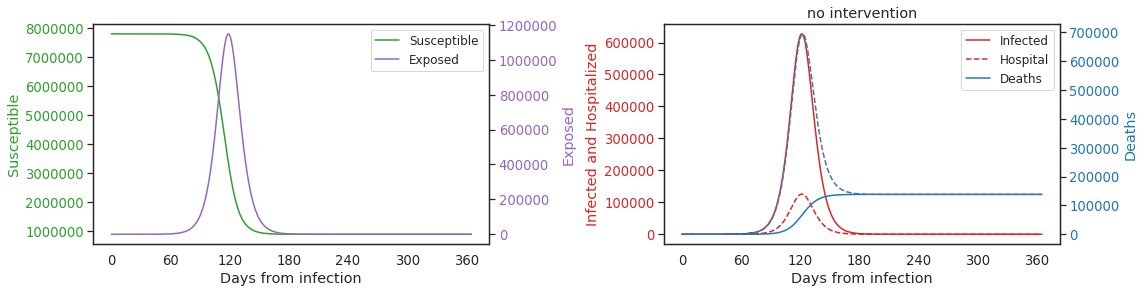

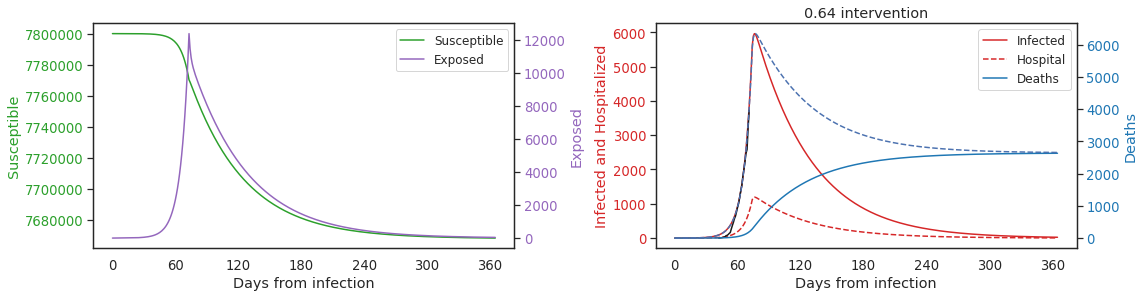

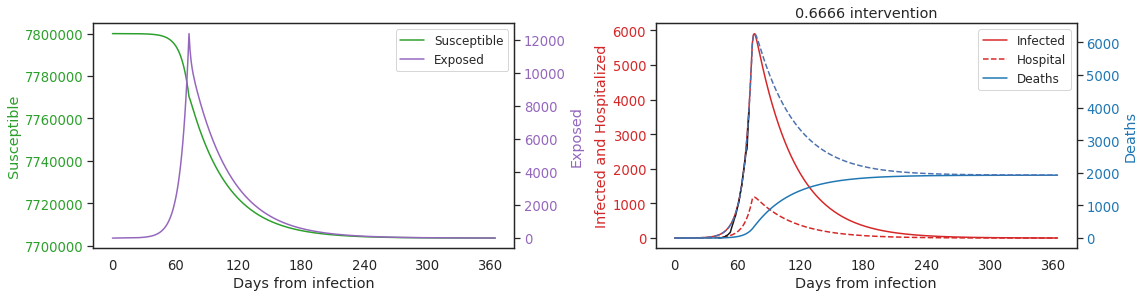

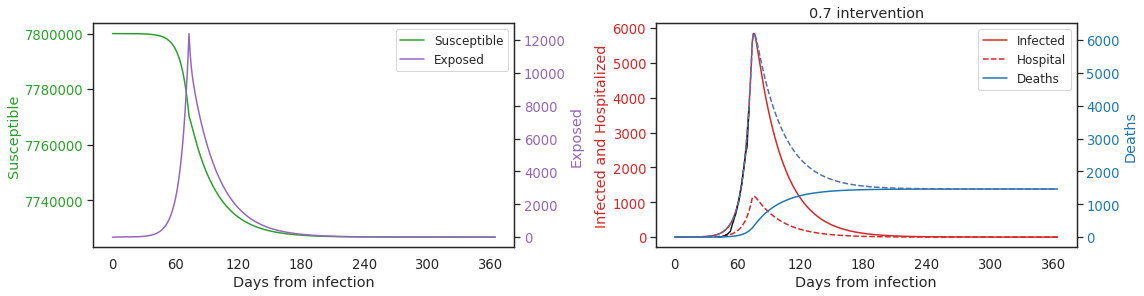

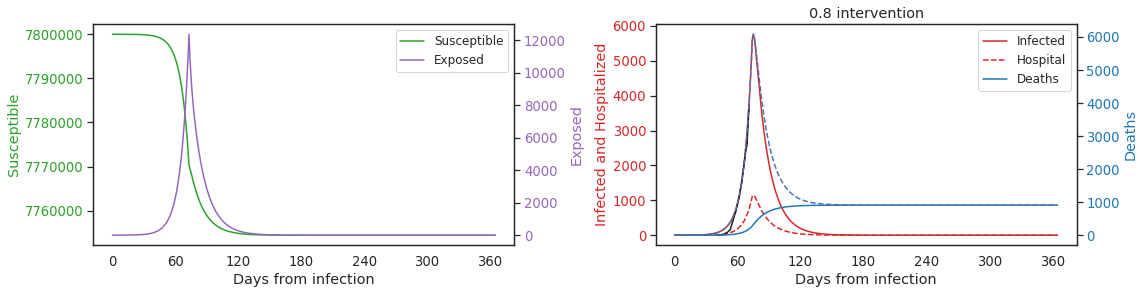

In [54]:
# without intervention
system = make_system(people, inv_day, R0, init_inf, init_deaths, init_recs,
                     death_rate, T_inc, T_inf, T_death, T_hosp, T_rec,
                     hosp_rate, T_tohosp, R0)
results = run_simulation(system, update_func)
# plot_results(results, system)
plot_results_lines(results, system, cases, offset)
plt.title('no intervention')

# with intervention
inv_day = 30 + offset  # day of intervention [day]
inv_per = 0.64  # intervention percent reduction in transmission
Rt = (1.0 - inv_per) * R0  # modified contagiousness factor after inv_day
system_interfere = make_system(people, inv_day, R0, init_inf, init_deaths,
                               init_recs, death_rate, T_inc, T_inf, T_death,
                               T_hosp, T_rec, hosp_rate, T_tohosp, Rt)
results = run_simulation(system_interfere, update_func)
plot_results_lines(results, system_interfere, cases, offset)
plt.title(str(inv_per) + ' intervention')

# with intervention
inv_day = 30 + offset  # day of intervention [day]
inv_per = 0.6666  # intervention percent reduction in transmission
Rt = (1.0 - inv_per) * R0  # modified contagiousness factor after inv_day
system_interfere = make_system(people, inv_day, R0, init_inf, init_deaths,
                               init_recs, death_rate, T_inc, T_inf, T_death,
                               T_hosp, T_rec, hosp_rate, T_tohosp, Rt)
results = run_simulation(system_interfere, update_func)
plot_results_lines(results, system_interfere, cases, offset)
plt.title(str(inv_per) + ' intervention')

# with intervention
inv_day = 30 + offset  # day of intervention [day]
inv_per = 0.7  # intervention percent reduction in transmission
Rt = (1.0 - inv_per) * R0  # modified contagiousness factor after inv_day
system_interfere = make_system(people, inv_day, R0, init_inf, init_deaths,
                               init_recs, death_rate, T_inc, T_inf, T_death,
                               T_hosp, T_rec, hosp_rate, T_tohosp, Rt)
results = run_simulation(system_interfere, update_func)
plot_results_lines(results, system_interfere, cases, offset)
plt.title(str(inv_per) + ' intervention')

# with intervention
inv_day = 30 + offset  # day of intervention [day]
inv_per = 0.8  # intervention percent reduction in transmission
Rt = (1.0 - inv_per) * R0  # modified contagiousness factor after inv_day
system_interfere = make_system(people, inv_day, R0, init_inf, init_deaths,
                               init_recs, death_rate, T_inc, T_inf, T_death,
                               T_hosp, T_rec, hosp_rate, T_tohosp, Rt)
results = run_simulation(system_interfere, update_func)
plot_results_lines(results, system_interfere, cases, offset)
plt.title(str(inv_per) + ' intervention')

print(
    'day index 42 is 2/27, etc so (60,3/26), (90,4/25), (120,5/25)... just take it as 60-90=April 90-120=May 120-150=June 150-180=July 180-210=August 210-240=September'
)

basically this is saying we need either a less than 40 or greater than 65% (prefferable) rate to not knock out for too long more than half a year. See that vertical asymptote of time showing prolonged and continual infection? the closer to half of the population it gets too the longer subduing it will take.


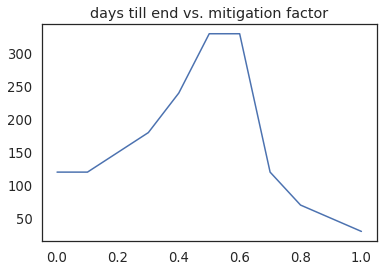

In [56]:
deaths_pred = [
    1.2 * 10**6, 1.2 * 10**6, 1.2 * 10**6, 1.2 * 10**6, 0.8 * 10**6,
    54 * 10**3, 6000, 1500, 1000, 800, 700
]
max_hosp = [
    1.2 * 10**6, 10**6, 80 * 10**3, 50 * 10**3, 25 * 10**3, 10 * 10**3, 1000,
    1000, 1000, 1000, 1000
]
days_end = [120, 120, 150, 180, 240, 330, 330, 120, 70, 50, 30]

plt.plot(linspace(0, 1, 11), days_end, 'b')
plt.title('days till end vs. mitigation factor')

print(
    'basically this is saying we need either a less than 40 or greater than 65% (prefferable) rate to not knock out for too long more than half a year. See that vertical asymptote of time showing prolonged and continual infection? the closer to half of the population it gets too the longer subduing it will take.'
)

my best guess is peak 1000 hospitalized, 5000 dead, goes through 300000 people in WA, double that if it's worse/not as preventable as I thought
if no mitigation this says peak 100000 hospital, 150000 dead, goes through 7mill in WA


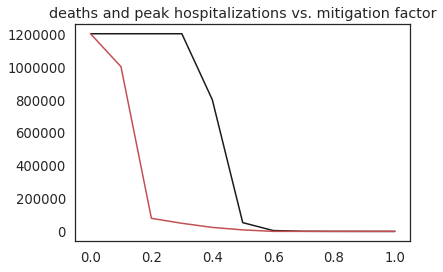

In [67]:
start_idx = 0
plt.plot(linspace(0, 1, 11)[start_idx:11], deaths_pred[start_idx:11], 'k')
plt.plot(linspace(0, 1, 11)[start_idx:11], max_hosp[start_idx:11], 'r')
plt.title('deaths and peak hospitalizations vs. mitigation factor')

print(
    'my best guess is peak 1000 hospitalized, 5000 dead, goes through 300000 people in WA, double that if it\'s worse/not as preventable as I thought'
)
print(
    'if no mitigation this says peak 100000 hospital, 150000 dead, goes through 7mill in WA'
)